In [1]:
#Imports
import matplotlib.pyplot as plt
import numpy as np
from nilearn import datasets, plotting, image
from nilearn.maskers import NiftiMapsMasker
from sklearn.decomposition import FastICA
import pandas as pd
import tarfile
import gzip

# Data Pre-Processing

Netmat matricies Data file: **Data/HCP/HCP_PTN1200/netmats_3T_HCP1200_MSMAll_ICAd100_ts2.tar.gz**

- 1003 subjects
- For time series (4800 total timepoints)

In [2]:
hcp_file = 'Data/netmats_3T_HCP1200_MSMAll_ICAd100_ts2.tar.gz'

In [3]:
# Read Network Matricies
data_raw = []

with gzip.open(hcp_file, 'rb') as gz_file:
    with tarfile.open(fileobj=gz_file, mode='r') as tar:
        
        # Extract a text file
        for file in tar.getnames():
            if file.endswith('.txt'):
                # Read the content and load it into a NumPy array
                subjects = np.loadtxt(tar.extractfile(file), dtype=float)
                
                ICAd = int(np.sqrt(subjects.shape[1]))
                
                # Convert into matrix
                matrix = np.array([np.reshape(i, (ICAd, ICAd)) for i in subjects])
                data_raw.append(matrix)

In [4]:
data_raw[0].shape

(1003, 100, 100)

In [5]:
data_raw[1].shape

(1003, 100, 100)

1. netmats1: Using "full" normalized temporal correlation between every node timeseries and every other. This is a common approach and is
very simple, but it has various practical and interpretational disadvantages [Smith 2012].

In [6]:
net_mat1 = data_raw[0]
net_mat1[0]

array([[ 0.     , -1.5323 , 35.936  , ...,  0.80711,  4.5279 ,  4.9836 ],
       [-1.5323 ,  0.     , -9.1569 , ...,  0.52657,  3.277  ,  1.7371 ],
       [35.936  , -9.1569 ,  0.     , ..., -0.67059,  0.22134, -0.87813],
       ...,
       [ 0.80711,  0.52657, -0.67059, ...,  0.     ,  1.2762 ,  3.6853 ],
       [ 4.5279 ,  3.277  ,  0.22134, ...,  1.2762 ,  0.     ,  4.497  ],
       [ 4.9836 ,  1.7371 , -0.87813, ...,  3.6853 ,  4.497  ,  0.     ]])

2. netmats2: Using partial temporal correlation between nodes' timeseries. This aims to estimate direct connection strengths better than
achieved by full correlation. To slightly improve the estimates of partial correlation coefficients, a small amount of L2 regularization is
applied (setting rho=0.01 in the Ridge Regression netmats option in FSLNets) [Smith OHBM 2014, FSLNets].

In [7]:
net_mat2 = data_raw[1]
net_mat2[0]

array([[ 0.     ,  0.61676,  9.5727 , ...,  0.38609, -0.18148,  2.4279 ],
       [ 0.61676,  0.     ,  2.856  , ..., -0.7748 , -0.43767, -1.0479 ],
       [ 9.5727 ,  2.856  ,  0.     , ...,  0.34688, -0.34526, -1.2173 ],
       ...,
       [ 0.38609, -0.7748 ,  0.34688, ...,  0.     , -0.30947,  3.0171 ],
       [-0.18148, -0.43767, -0.34526, ..., -0.30947,  0.     ,  0.26007],
       [ 2.4279 , -1.0479 , -1.2173 , ...,  3.0171 ,  0.26007,  0.     ]])

In [8]:
id_file = 'Data/IDs/subjectIDs.txt'
id_recon1_file = 'Data/IDs/subjectIDs_recon1.txt'
id_recon2_file = 'Data/IDs/subjectIDs_recon2.txt'

In [9]:
# Read Subject IDs
subject_IDs = np.loadtxt(id_file, dtype=int)

In [10]:
subject_IDs.shape

(1003,)

In [11]:
# Read Subject Descriptions
subject_data = pd.read_csv('Data/subjects.csv', index_col = 'Subject')

In [12]:
subject_data.head()

,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,3T_Full_Task_fMRI,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
Subject,,,,,,,,,,,,,,,,,,,,,
100004,S900,Q06,M,22-25,False,0,0,0,0.0,False,...,5.2,101.12,86.45,2.0,45.9,107.17,105.31,1.80,0.0,1.80
100206,S900,Q11,M,26-30,True,1,1,4,100.0,True,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
100307,Q1,Q01,F,26-30,True,1,1,4,100.0,True,...,3.6,101.12,86.45,0.0,38.6,71.69,71.76,1.76,0.0,1.76
100408,Q3,Q03,M,31-35,True,1,1,4,100.0,True,...,2.0,108.79,98.04,2.0,52.6,114.01,113.59,1.76,2.0,1.68
100610,S900,Q08,M,26-30,True,2,1,4,100.0,True,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88


In [13]:
subject_data = subject_data[['Gender', 'Age']]
subject_data.head()

,Gender,Age
Subject,,
100004,M,22-25
100206,M,26-30
100307,F,26-30
100408,M,31-35
100610,M,26-30


In [14]:
net_mat2[0]

array([[ 0.     ,  0.61676,  9.5727 , ...,  0.38609, -0.18148,  2.4279 ],
       [ 0.61676,  0.     ,  2.856  , ..., -0.7748 , -0.43767, -1.0479 ],
       [ 9.5727 ,  2.856  ,  0.     , ...,  0.34688, -0.34526, -1.2173 ],
       ...,
       [ 0.38609, -0.7748 ,  0.34688, ...,  0.     , -0.30947,  3.0171 ],
       [-0.18148, -0.43767, -0.34526, ..., -0.30947,  0.     ,  0.26007],
       [ 2.4279 , -1.0479 , -1.2173 , ...,  3.0171 ,  0.26007,  0.     ]])

In [15]:
# Combine the netmats and id data in data frame
net_mat_data = pd.Series(dict(zip(subject_IDs, net_mat2))).to_frame().rename(columns = {0 : 'netmat'})
net_mat_data

,netmat
100206,"[[0.0, 0.61676, 9.5727, -5.4959, 0.34639, 3.00..."
100307,"[[0.0, -0.29664, 17.317, -9.0467, -0.28723, 1...."
100408,"[[0.0, 1.6486, 6.6189, -8.8877, 1.4337, 1.006,..."
100610,"[[0.0, -0.90275, 7.7215, -8.3907, 3.3144, 2.93..."
101006,"[[0.0, -0.088768, 9.4979, -10.412, 1.0646, 4.3..."
...,...
992673,"[[0.0, -0.11536, 7.1338, -5.5322, 0.34004, 1.6..."
992774,"[[0.0, 0.25353, 8.0265, -6.2072, 4.1589, 1.582..."
993675,"[[0.0, -1.0378, 10.709, -3.3224, -0.090704, 2...."
994273,"[[0.0, 0.64613, 11.471, -5.5137, 1.9357, 4.259..."


In [16]:
# Now merge the two lists
data = subject_data.join(net_mat_data, how = 'right')

In [17]:
data.head()

,Gender,Age,netmat
100206,M,26-30,"[[0.0, 0.61676, 9.5727, -5.4959, 0.34639, 3.00..."
100307,F,26-30,"[[0.0, -0.29664, 17.317, -9.0467, -0.28723, 1...."
100408,M,31-35,"[[0.0, 1.6486, 6.6189, -8.8877, 1.4337, 1.006,..."
100610,M,26-30,"[[0.0, -0.90275, 7.7215, -8.3907, 3.3144, 2.93..."
101006,F,31-35,"[[0.0, -0.088768, 9.4979, -10.412, 1.0646, 4.3..."


In [18]:
data.shape

(1003, 3)

_________

# EDA

## Permutation Testing  
Here, we will perform an A/B test to compare the pairwise correlation matrices of male and female subjects.

## Step 1. Find observed difference in male and female subjects

In [19]:
# load in data
# fp = "Data/data_clean.csv"

sex = "Gender" # column name for male or female assignment
netmat = "netmat"

df = data[[sex, netmat]]

m = "M"
f = "F"
male_df = df[df[sex] == m] # get all males
female_df = df[df[sex] == f] # get all females

avg_netmat = df.groupby(sex).mean()[netmat] # find element-wise averages in male correlation matrix and female correlation matrix
m_avg_netmat = avg_netmat.loc[m]
f_avg_netmat = avg_netmat.loc[f]

diff_avg_netmat = m_avg_netmat - f_avg_netmat # find element-wise difference in averages between male and female correlation matrix (M - F)
diff_avg_netmat

array([[ 0.        ,  0.16733586,  0.07263026, ...,  0.03182092,
         0.02316771,  0.14288038],
       [ 0.16733586,  0.        , -0.48334823, ...,  0.18267227,
        -0.05206851, -0.07870042],
       [ 0.07263026, -0.48334823,  0.        , ...,  0.23223379,
         0.04712767,  0.01167113],
       ...,
       [ 0.03182092,  0.18267227,  0.23223379, ...,  0.        ,
        -0.04163293,  0.11617937],
       [ 0.02316771, -0.05206851,  0.04712767, ..., -0.04163293,
         0.        , -0.04420474],
       [ 0.14288038, -0.07870042,  0.01167113, ...,  0.11617937,
        -0.04420474,  0.        ]])

## Aggregated Pairwise Correlation Matrices

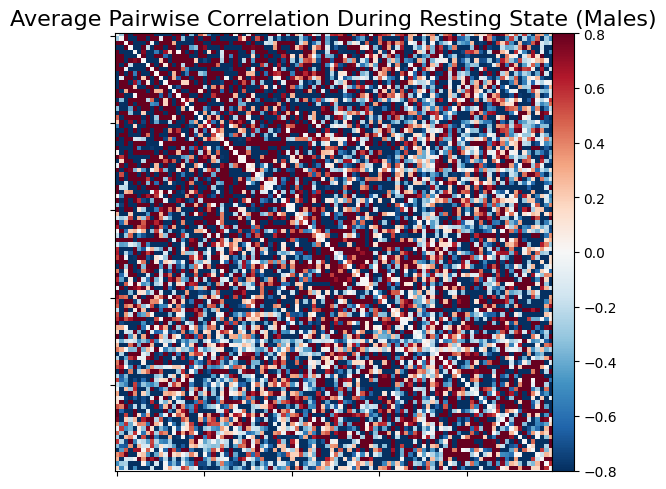

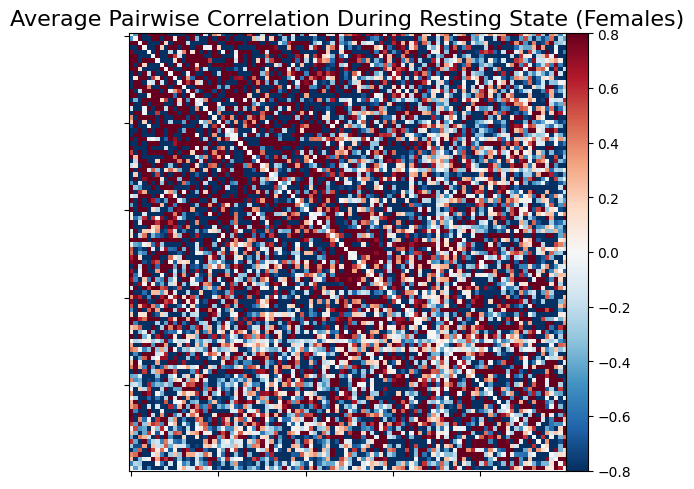

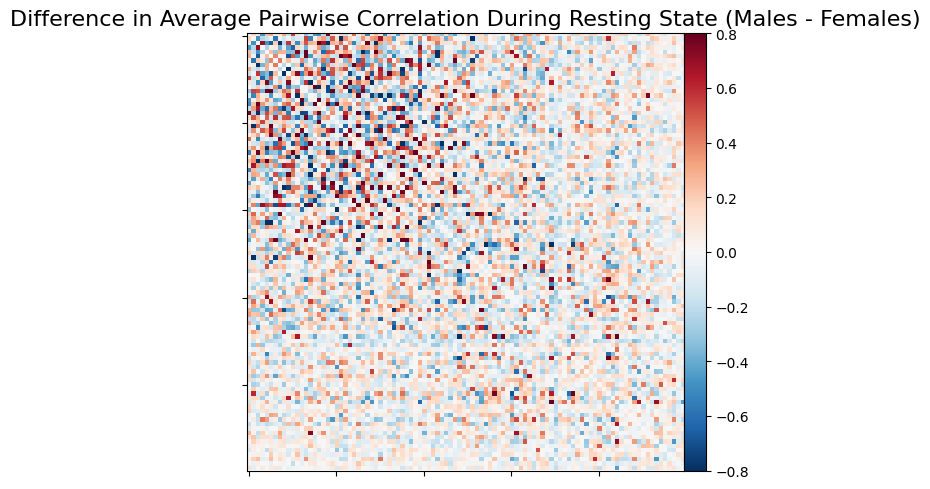

In [20]:
plotting.plot_matrix( # visualize element-wise average of males
    m_avg_netmat, colorbar=True, vmax=0.8, vmin=-0.8, title = "Average Pairwise Correlation During Resting State (Males)")

plotting.plot_matrix( # visualize element-wise average of females
    f_avg_netmat, colorbar=True, vmax=0.8, vmin=-0.8, title = "Average Pairwise Correlation During Resting State (Females)")

plotting.plot_matrix( # visualize element-wise difference of averages
    diff_avg_netmat, colorbar=True, vmax=0.8, vmin=-0.8, title = "Difference in Average Pairwise Correlation During Resting State (Males - Females)")

In [116]:
# "overall" difference
observed_overall_diff = np.linalg.norm(diff_avg_netmat)
observed_overall_diff

25.708548144957906

## Step 2. Perform A/B Testing

In [117]:
num_shuffles = 500
differences = [0] * num_shuffles
overall_differences = [0] * num_shuffles
for i in range(num_shuffles):
    sex_shuffled = np.random.permutation(df[sex]) # shuffle sex
    shuffled = df.assign(shuffled = sex_shuffled)  
    group_means = shuffled.groupby('shuffled')[netmat].mean() # find average for each pairwise correlation
    difference = group_means.loc[m] - group_means.loc[f] # find difference of each average pairwise correlation in males and females
    differences[i] = difference
    overall_differences[i] = np.linalg.norm(difference)

# just display the first ten differences.
differences[:10]

[array([[ 0.        ,  0.0106798 ,  0.09456325, ...,  0.00582872,
          0.07533349, -0.0165588 ],
        [ 0.0106798 ,  0.        , -0.02773193, ..., -0.00618615,
         -0.00087579, -0.01252179],
        [ 0.09456325, -0.02773193,  0.        , ...,  0.03500558,
          0.04127337, -0.01121027],
        ...,
        [ 0.00582872, -0.00618615,  0.03500558, ...,  0.        ,
          0.03805665,  0.07164927],
        [ 0.07533349, -0.00087579,  0.04127337, ...,  0.03805665,
          0.        , -0.01070966],
        [-0.0165588 , -0.01252179, -0.01121027, ...,  0.07164927,
         -0.01070966,  0.        ]]),
 array([[ 0.        , -0.03414296,  0.01209295, ...,  0.03008802,
         -0.01588049,  0.00206776],
        [-0.03414296,  0.        ,  0.06915189, ..., -0.09371495,
          0.0366402 ,  0.08445418],
        [ 0.01209295,  0.06915189,  0.        , ...,  0.02540848,
          0.00759354, -0.06776814],
        ...,
        [ 0.03008802, -0.09371495,  0.02540848, ...,  

In [118]:
# overall differences
overall_differences[:10]

[8.41729160087096,
 8.105271778829435,
 8.906504255464982,
 8.220907636631441,
 8.694085232581346,
 8.288251039337421,
 8.570211640496668,
 8.041991196955546,
 8.599581303957443,
 8.074716181675274]

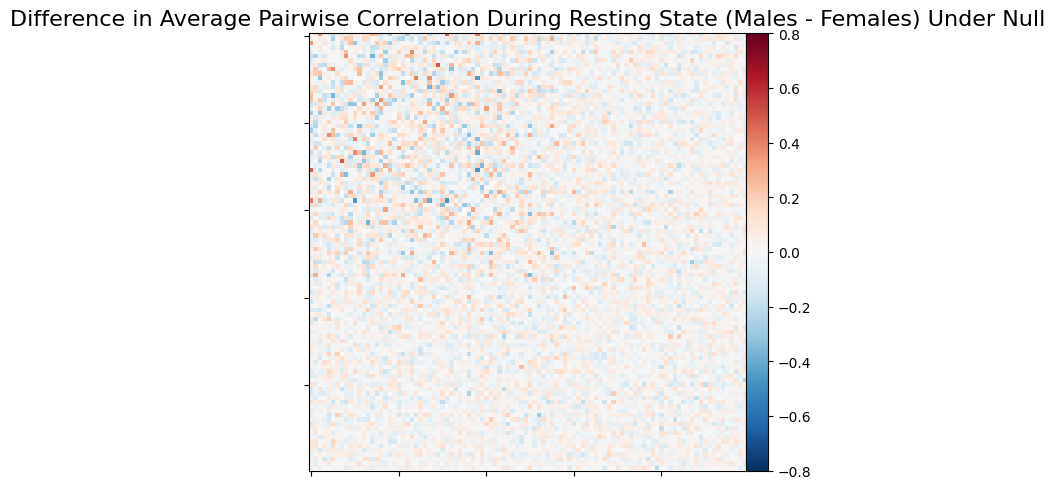

In [75]:
plotting.plot_matrix( # visualize element-wise difference of averages
    differences[10], colorbar=True, vmax=0.8, vmin=-0.8, title = "Difference in Average Pairwise Correlation During Resting State (Males - Females) Under Null")

In [23]:
(np.array(differences) > diff_avg_netmat).shape # 500 pairwise correlation matrices (100 total regions)

(500, 100, 100)

In [106]:
len(overall_differences)

500

## P-values

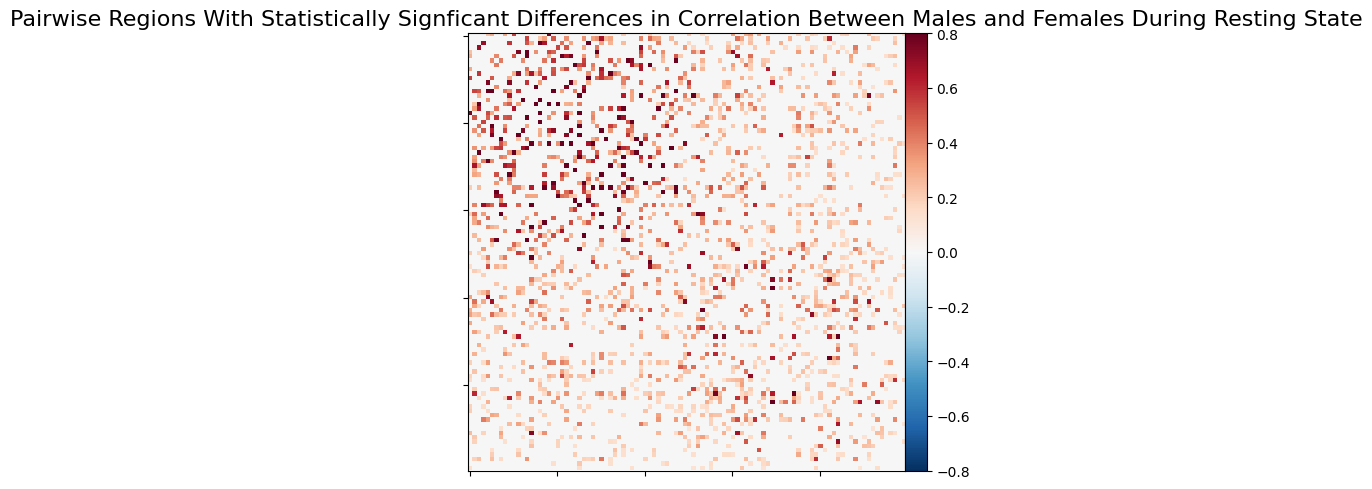

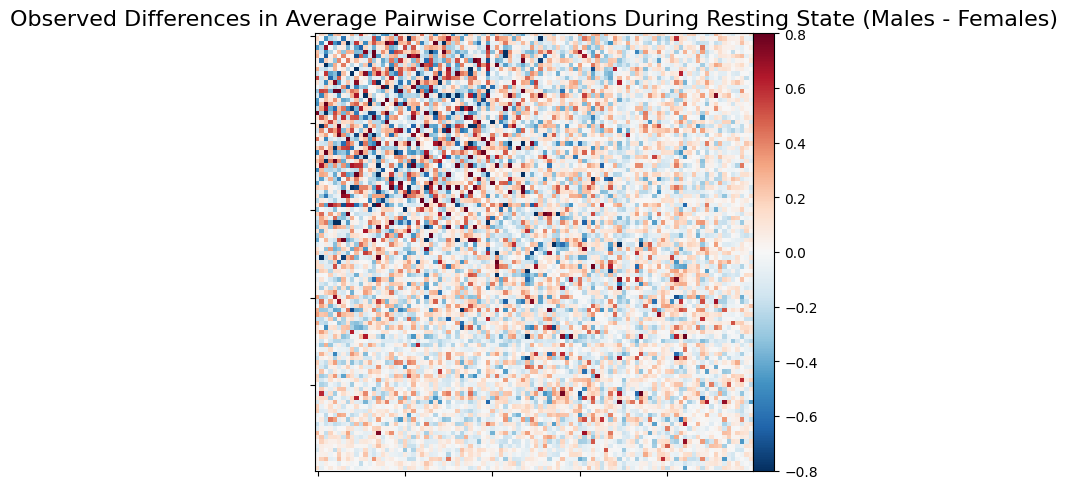

In [55]:
p_vals = np.mean((np.array(differences) > diff_avg_netmat), axis=0) # proportion of differences greater than observed difference for each pairwise region
significant_regions = np.where(p_vals < 0.01, diff_avg_netmat, 0)

plotting.plot_matrix( # visualize element-wise difference of averages
    significant_regions, colorbar=True, vmax=0.8, vmin=-0.8, title = "Pairwise Regions With Statistically Signficant Differences in Correlation Between Males and Females During Resting State")

plotting.plot_matrix( # visualize element-wise difference of averages
    diff_avg_netmat, colorbar=True, vmax=0.8, vmin=-0.8, title = "Observed Differences in Average Pairwise Correlations During Resting State (Males - Females)")

Text(0, 0.5, 'count')

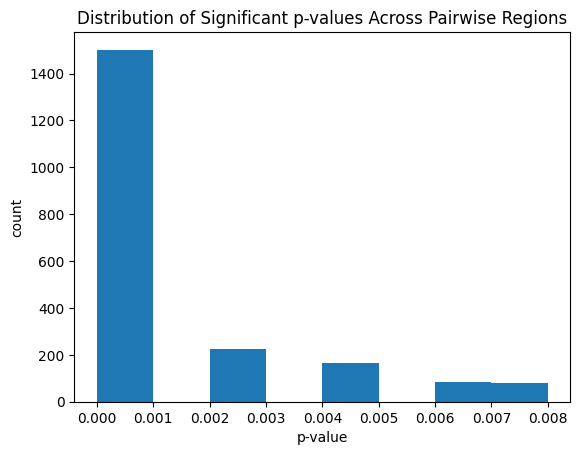

In [155]:
# distribution of p-values
plt.hist(p_vals[p_vals < 0.01], bins=8)
plt.title('Distribution of Significant p-values Across Pairwise Regions')
plt.xlabel('p-value')
plt.ylabel('count')

In [120]:
# p-value with overall difference
(overall_differences > observed_overall_diff).mean()

0.0

## Step 3. Exploratory Values

Of all unique pairwise regions, what proportion of them have statistically significant differences in correlation between males and females?

In [ ]:
1 - (get_upper_triangular(significant_regions) == 0).mean() # proportion of all pairwise regions that have statistically significant difference

0.19797979797979803

How much of the overall difference between males and females is attributable to the pairwise regions with statistically significant differences in correlation between males and females?

In [123]:
np.linalg.norm(significant_regions) / observed_overall_diff # proportion of the overall difference attributable to significant regions


0.7095003661554984

## Highest Difference

In [177]:
m_significant_regions = np.where(significant_regions == 0, 0, m_avg_netmat)
f_significant_regions = np.where(significant_regions == 0, 0, f_avg_netmat)


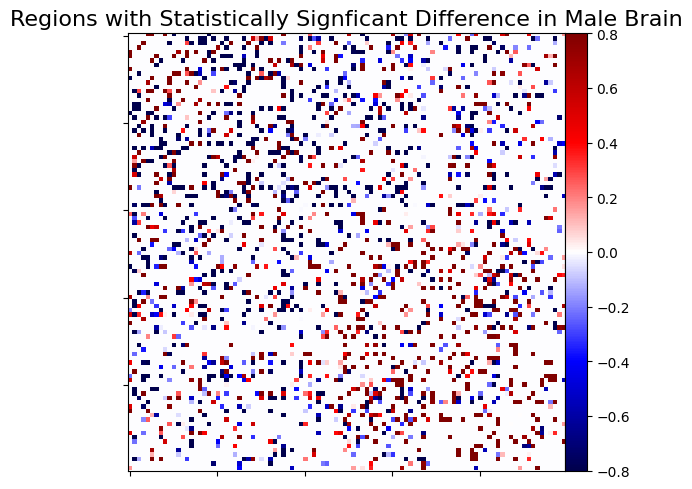

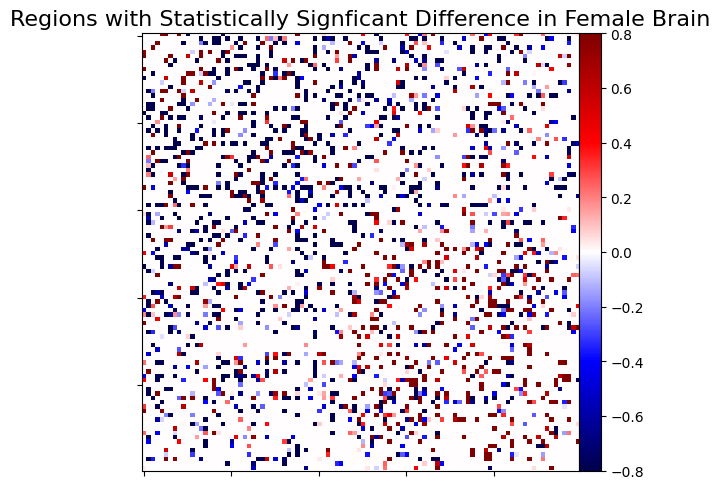

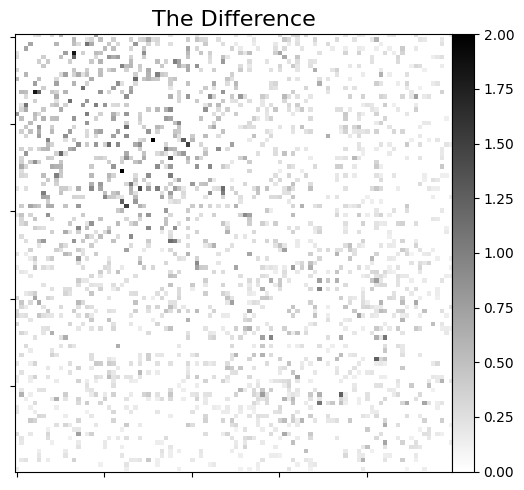

In [539]:
plotting.plot_matrix( # visualize element-wise difference of averages
    m_significant_regions, colorbar=True, vmax=0.8, vmin=-0.8, title = "Regions with Statistically Signficant Difference in Male Brain", cmap='seismic')
plotting.plot_matrix( # visualize element-wise difference of averages
    f_significant_regions, colorbar=True, vmax=0.8, vmin=-0.8, title = "Regions with Statistically Signficant Difference in Female Brain", cmap='seismic')
plotting.plot_matrix( # visualize element-wise difference of averages
    np.abs(m_significant_regions - f_significant_regions), colorbar=True, vmax=2, vmin=0, title = "The Difference", cmap='binary')

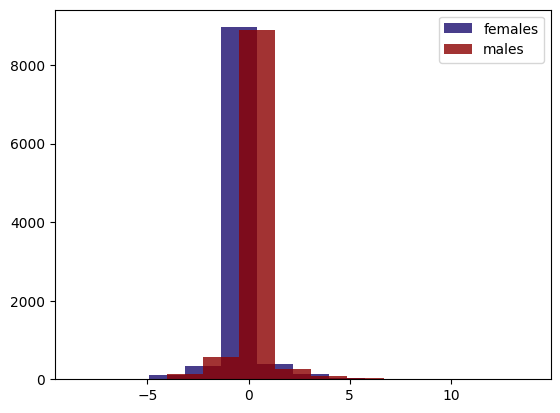

In [ ]:
plt.hist(f_significant_regions.flatten(), bins=12, label="females", color="darkslateblue")
plt.hist(m_significant_regions.flatten(), bins=12, label="males", alpha=0.8, color="darkred")


plt.legend()

## Most statistically significant

In [338]:
m_most_diff = np.where(p_vals == np.min(p_vals), m_significant_regions, 0)
f_most_diff = np.where(p_vals == np.min(p_vals), f_significant_regions, 0)

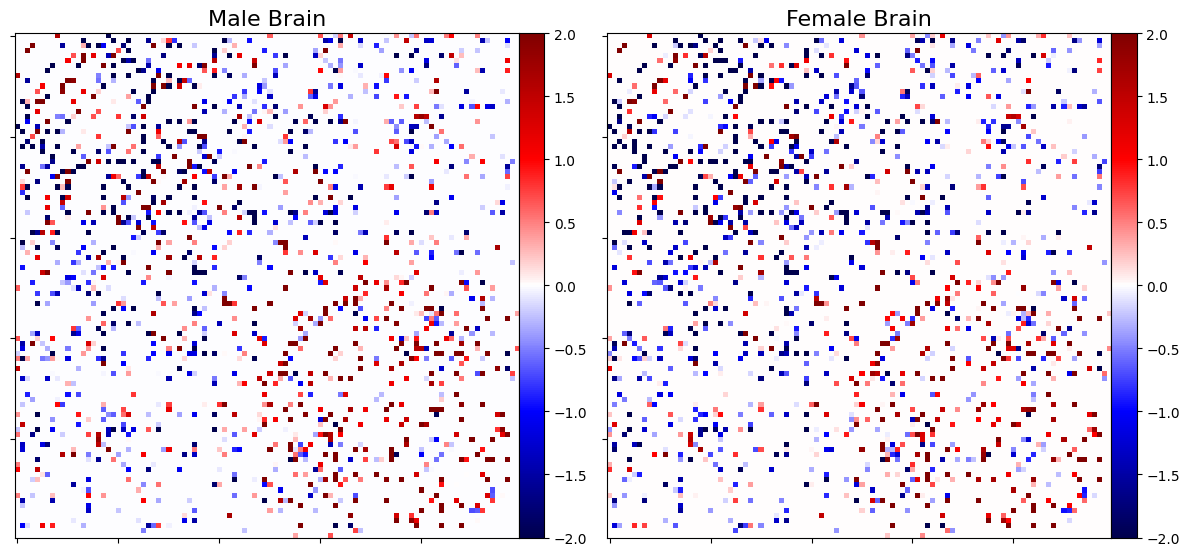

In [417]:
# Create a 1x2 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first matrix on the left
plotting.plot_matrix(m_most_diff, colorbar=True, vmax=2, vmin=-2, title="Male Brain", axes=axes[0], cmap='seismic')

# Plot the second matrix on the right
plotting.plot_matrix(f_most_diff, colorbar=True, vmax=2, vmin=-2, title="Female Brain", axes=axes[1], cmap='seismic')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

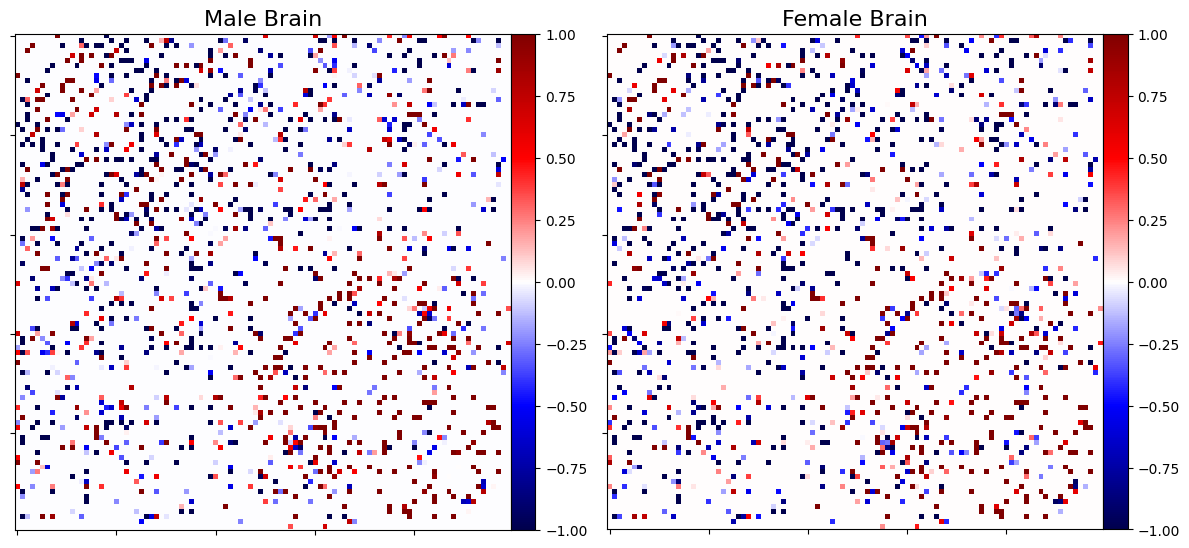

In [415]:
# Create a 1x2 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first matrix on the left
plotting.plot_matrix(m_most_diff, colorbar=True, vmax=1, vmin=-1, title="Male Brain", axes=axes[0], cmap='seismic')

# Plot the second matrix on the right
plotting.plot_matrix(f_most_diff, colorbar=True, vmax=1, vmin=-1, title="Female Brain", axes=axes[1], cmap='seismic')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

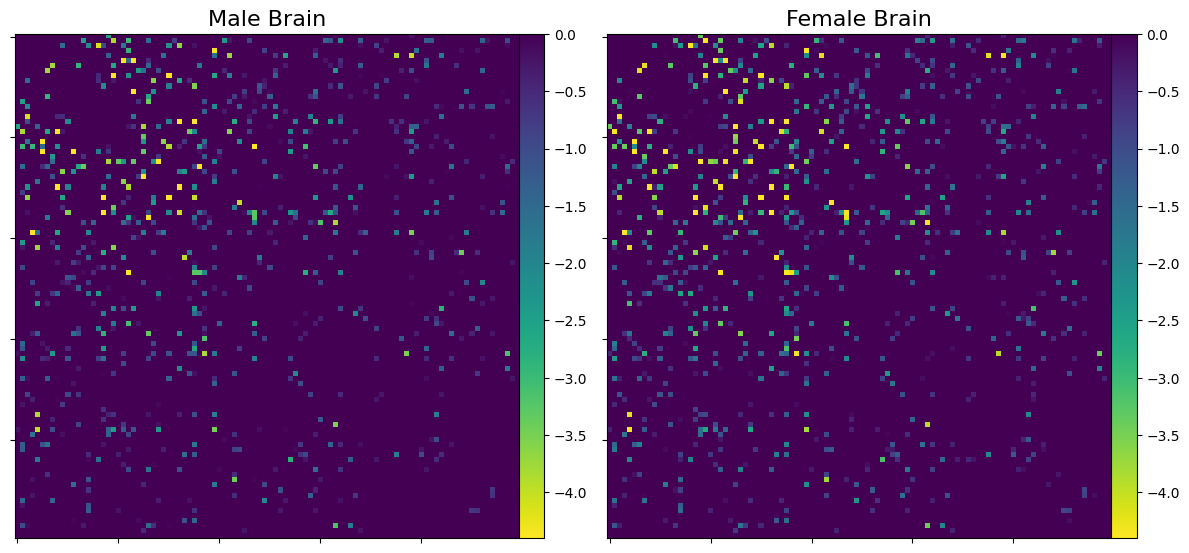

In [440]:
# Create a 1x2 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first matrix on the left
plotting.plot_matrix(m_most_diff, colorbar=True, vmax=-4, vmin=0, title="Male Brain", axes=axes[0], cmap="viridis_r")

# Plot the second matrix on the right
plotting.plot_matrix(f_most_diff, colorbar=True, vmax=-4, vmin=0, title="Female Brain", axes=axes[1], cmap="viridis_r")

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

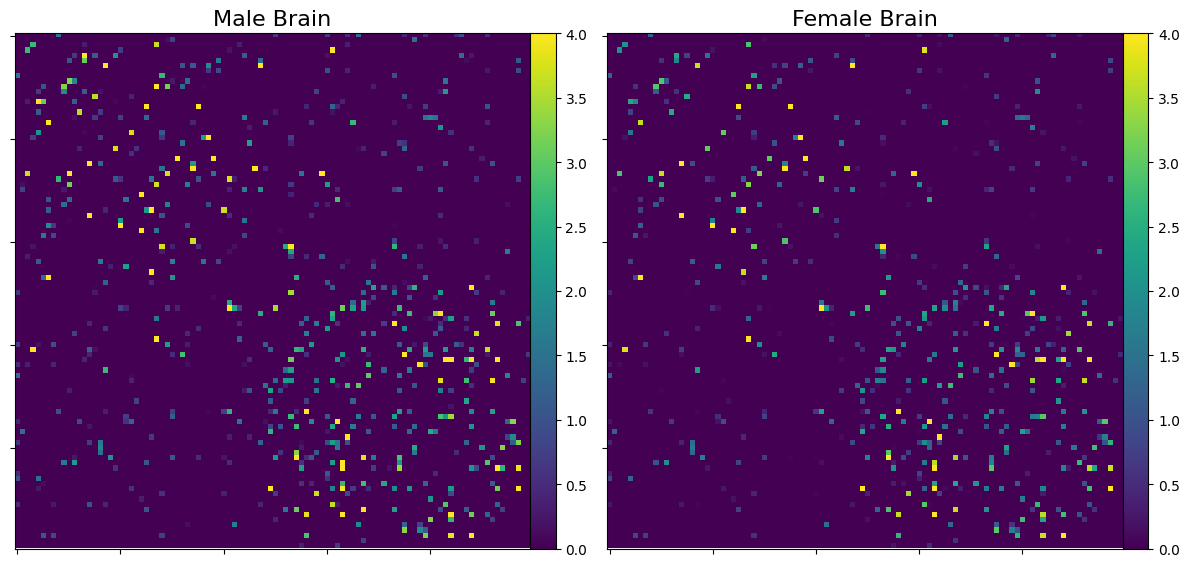

In [464]:
# Create a 1x2 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first matrix on the left
plotting.plot_matrix(m_most_diff, colorbar=True, vmax=4, vmin=0, title="Male Brain", axes=axes[0], cmap="viridis")

# Plot the second matrix on the right
plotting.plot_matrix(f_most_diff, colorbar=True, vmax=4, vmin=0, title="Female Brain", axes=axes[1], cmap="viridis")

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

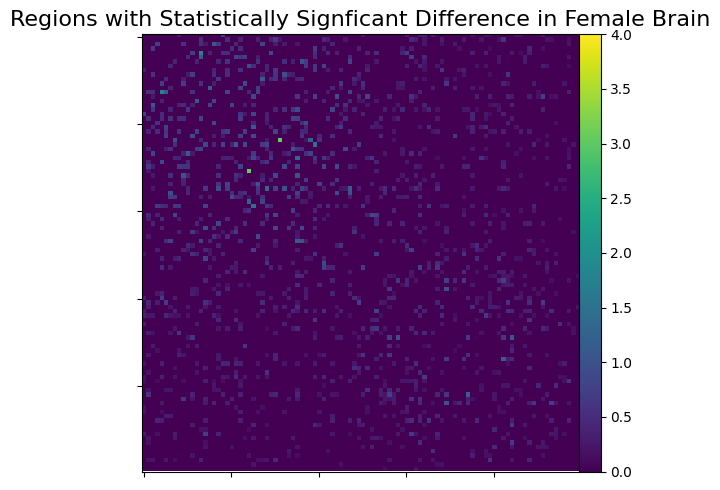

In [427]:
plotting.plot_matrix( # visualize element-wise difference of averages
    m_most_diff - f_most_diff, colorbar=True, vmax=4, vmin=0, title = "Regions with Statistically Signficant Difference in Female Brain", cmap='viridis')

In [51]:
def get_upper_triangular(symmetric_matrix):
    '''returns only the upper triangular values of a symmetric matrix'''
    num_pairwise = symmetric_matrix.shape[0]
    no_diagonal = 1
    return symmetric_matrix[np.triu_indices(n=num_pairwise, k=no_diagonal)]

def get_pairwise_sd(df):
    '''finds the standard deviation of each pairwise correlation'''
    N = df.shape[0]
    sq_diff = df[netmat].apply(lambda netmat: (netmat - m_avg_netmat) ** 2)
    return np.sqrt(sq_diff.sum() / df.shape[0])

In [27]:
data.to_csv('Data/data_clean.csv')